# Работа с датасетом

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lafore","key":"0ccefc12e2fcecfe73e8e378865459ad"}'}

In [ ]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ml-intensive-yandex-autumn-2023

100% 988M/988M [00:09<00:00, 122MB/s] 
100% 988M/988M [00:09<00:00, 109MB/s]


In [ ]:
!unzip ml-intensive-yandex-autumn-2023.zip

Создаем классы для Train и Test датасетов

In [ ]:
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
from torchvision.transforms.v2 import Compose, ToDtype, PILToTensor, Normalize, RandomRotation, RandomHorizontalFlip, CenterCrop, Pad, Resize
from PIL import Image
from random import randrange


class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, mask_mode=0):
        data = pd.read_csv('./data/train_answers.csv')
        data['img_name'] = data['id'].apply(lambda x: f'img_{x}.png')

        self.img_labels = data
        self.train_dir = './data/train_images/'
        self.mask_dir = './data/train_lung_masks/'
        # характеристики преобразования изображения
        self.transform = Compose([PILToTensor(), ToDtype(torch.float32, scale=True), Resize(224, antialias=None)])
        # режим маски 0 - выключено, 1 - включена(отображаются только лёгкие), 2 - частично включена(лёгкие имеют большее значение)
        self.mask_mode = mask_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        train_img_path = os.path.join(self.train_dir, self.img_labels.iloc[idx, 2])
        mask_img_path = os.path.join(self.mask_dir, self.img_labels.iloc[idx, 2])
        train_image = Image.open(train_img_path)
        mask_image = Image.open(mask_img_path)

        label = self.img_labels.iloc[idx, 1]
        # трансформация изображений
        train_image = self.transform(train_image)
        mask_image = self.transform(mask_image)
        # применение маски
        if self.mask_mode == 0:
            image = train_image
        elif self.mask_mode == 1:
            image = train_image * mask_image
        elif self.mask_mode == 2:
            image = train_image * 0.5 + mask_image * 0.5
            # можно изменять параметры частичной маски, но нам кажется, что должны быть такие

        # нормализация изображения
        image = Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))(image) * 0.25 + 0.5
        label = torch.tensor(label, dtype=torch.long)

        return image, label # срезы не работают


class TestDataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        # создание пустого датафрейма с соответствующими колонками
        data = pd.DataFrame(index = range(6920), columns=['id', 'img_name'])
        data['id'] = range(6920)
        data['img_name'] = data['id'].apply(lambda x: f'img_{x}.png')
        self.img_labels = data
        self.test_dir = './data/test_images/'
        # характеристики преобразования изображения
        self.transform = Compose([PILToTensor(), ToDtype(torch.float32, scale=True)])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        test_img_path = os.path.join(self.test_dir, self.img_labels.iloc[idx, 1])
        test_image = Image.open(test_img_path)
        test_image = self.transform(test_image)
        image = Resize(224, antialias=None)(image)

        if self.mask:
          mask_img_path = os.path.join(self.mask_dir, self.img_labels.iloc[idx, 1])
          mask_image = Image.open(mask_img_path)
          mask_image = self.transform(mask_image)
          # инверсия цветов картинки
          image = -1 * (test_image - 1) * mask_image
        else:
          image = test_image

        # нормализация изображения
        image = Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))(image) * 0.25 + 0.5
        return image # срезы не работают

In [ ]:
# функция для аугментации
def augmenting(image):
  aug_stack = Compose([RandomRotation(degrees=10), RandomHorizontalFlip(0.8)])
  image = aug_stack(image)
  zoomSize = randrange(-10, 11)
  if zoomSize < 0:
      image = CenterCrop(int(224 * (1 + zoomSize / 100)))(image)
  else:
      image = Pad(int(224 * zoomSize / 100))(image)
  return image

# создание трейнового датасета с mask_mode = 1
data = TrainDataset(1)
# разделение на тестовый и трейновый датасеты
train_data, test_data = torch.utils.data.random_split(data, [0.8, 0.2])
batch_size = 32
# создание трейнового и тестового лоадера
train_loader = DataLoader(train_data, batch_size)
test_loader = DataLoader(test_data, batch_size)


# Модели

In [ ]:
# модель, на которой мы получили лучший результат (f1=0.91157)
class CNN(nn.Module):
    def __init__(self, num_classes: int = 3, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
from torch import nn
# одна из первых моделей, которые мы использовали
class Model(nn.Module):
  def __init__(
        self, in_channels=3, intermediate_channels=16, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.conv4 = nn.Conv2d(intermediate_channels * self.expansion, intermediate_channels, kernel_size=5, stride=3)
        self.bn4 = nn.BatchNorm2d(intermediate_channels)
        self.conv5 = nn.Conv2d(intermediate_channels, in_channels, kernel_size=5, stride=3)
        self.bn5 = nn.BatchNorm2d(in_channels)
        self.pool = nn.MaxPool2d(kernel_size = 4, stride=4)
        self.flatten = nn.Flatten(-3)
        self.l1 = nn.Linear(108, 54)
        self.l2 = nn.Linear(54, 26)
        self.l3 = nn.Linear(26, 3)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.drop(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.drop(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.drop(x)

    x = self.conv4(x)
    x = self.bn4(x)
    x = self.relu(x)
    x = self.drop(x)

    x = self.conv5(x)
    x = self.bn5(x)
    x = self.pool(x)
    x = self.drop(x)

    x = self.flatten(x)
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    x = self.l3(x)

    return x

In [ ]:
from torch import nn


# одна из основных моделей, которую мы использовали в работе над проектом
class Model_1(nn.Module):
  def __init__(self, in_channels=3, intermediate_channels=[32, 64, 128], stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, intermediate_channels[0], kernel_size=3, stride=1)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(intermediate_channels[0], intermediate_channels[1], kernel_size=3, stride=1)
    self.conv3 = nn.Conv2d(intermediate_channels[1], intermediate_channels[2], kernel_size=3, stride=1)
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(128 * 26 * 26, 64)
    self.l2 = nn.Linear(64, 3)
    self.logsoftmax = nn.LogSoftmax(1)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.dropout(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.dropout(x)

    x = self.conv3(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.dropout(x)

    x = self.flatten(x)
    x = self.l1(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.l2(x)
    x = self.logsoftmax(x)
    return x


# Сегментация

In [ ]:
import torch
import torch.nn as nn

# модель для сегментации изображений
# она обучалась на половине трейнового датасета 20 эпох lr=1e-5, оптимайзер Adam
class batchnorm_relu(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.bn = nn.BatchNorm2d(in_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        return x

class residual_block(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()

        """ Convolutional layer """
        self.b1 = batchnorm_relu(in_c)
        self.c1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
        self.b2 = batchnorm_relu(out_c)
        self.c2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, stride=1)

        """ Shortcut Connection (Identity Mapping) """
        self.s = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0, stride=stride)

    def forward(self, inputs):
        x = self.b1(inputs)
        x = self.c1(x)
        x = self.b2(x)
        x = self.c2(x)
        s = self.s(inputs)

        skip = x + s
        return skip

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.r = residual_block(in_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.r(x)
        return x

class Segmentation(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder 1 """
        self.c11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.br1 = batchnorm_relu(64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(3, 64, kernel_size=1, padding=0)

        """ Encoder 2 and 3 """
        self.r2 = residual_block(64, 128, stride=2)
        self.r3 = residual_block(128, 256, stride=2)

        """ Bridge """
        self.r4 = residual_block(256, 512, stride=2)

        """ Decoder """
        self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Output """
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip3)

        """ Decoder """
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)

        """ output """
        output = self.output(d3)
        output = self.sigmoid(output)

        return output


# Обучение моделей и получение предсказаний

In [ ]:
#!pip install torchsummary
from torchsummary import summary
model = CNN()
with torch.no_grad():
    x, y = next(iter(train_loader))
    print(f'x = {x}')
    print(f'y_true = {y}')
    print(f'y_pred = {model(x).argmax(1)}')

# проверка коректности модели
summary(model, (3, 224, 224), device="cpu")


x = tensor([[[[0.9331, 0.8962, 0.7910,  ..., 0.0585, 0.0585, 0.0403],
          [0.8937, 0.7817, 0.5514,  ..., 0.0549, 0.0549, 0.0367],
          [0.8581, 0.7090, 0.4711,  ..., 0.0549, 0.0549, 0.0367],
          ...,
          [0.9229, 0.7913, 0.5194,  ..., 0.0694, 0.0734, 0.0560],
          [0.9421, 0.8059, 0.5314,  ..., 0.0865, 0.0923, 0.0756],
          [0.9571, 0.8185, 0.5438,  ..., 0.1180, 0.1255, 0.1090]],

         [[0.9331, 0.8962, 0.7910,  ..., 0.0585, 0.0585, 0.0403],
          [0.8937, 0.7817, 0.5514,  ..., 0.0549, 0.0549, 0.0367],
          [0.8581, 0.7090, 0.4711,  ..., 0.0549, 0.0549, 0.0367],
          ...,
          [0.9229, 0.7913, 0.5194,  ..., 0.0694, 0.0734, 0.0560],
          [0.9421, 0.8059, 0.5314,  ..., 0.0865, 0.0923, 0.0756],
          [0.9571, 0.8185, 0.5438,  ..., 0.1180, 0.1255, 0.1090]],

         [[0.9331, 0.8962, 0.7910,  ..., 0.0585, 0.0585, 0.0403],
          [0.8937, 0.7817, 0.5514,  ..., 0.0549, 0.0549, 0.0367],
          [0.8581, 0.7090, 0.4711,  ..

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# функция обучения и теста
def run(model, dataloader, loss_function, optimizer=None):
  if optimizer:
    model.train()
  else:
    model.eval()

  total_loss = 0
  predictions = []

  for X, y in dataloader:
    if optimizer is not None:
      X = augmenting(X)
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_function(pred, y)
    total_loss += loss.item()
    if optimizer is not None:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    else:
      predictions.append(pred.argmax(dim=1))


  return total_loss / len(dataloader), predictions if optimizer is None else total_loss / len(dataloader)

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# функции вывода графиков
def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()


In [ ]:
# модель обучалась несколько раз по 30 эпох
batch_size = 32
NUM_EPOCHS = 30
model = CNN()
# выгрузка моделей
#path = '/content/1Model.pt'
#model.load_state_dict(torch.load(path))
model = model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


train_loss_hist = []
test_loss_hist = []
min_loss = float('inf')


for i in range(NUM_EPOCHS):
  train_loss = run(model, train_loader, loss_function, optimizer)
  train_loss_hist.append(train_loss)
  test_loss, predictions = run(model, test_loader, loss_function)
  min_loss = min(min_loss, test_loss)
  test_loss_hist.append(test_loss)
  show_losses(train_loss_hist, test_loss_hist)
  model_weights = model.state_dict()

Графики в процессе обучения основной модели CNN на датасете с mask mode = 1, mask mode = 0 соответственно

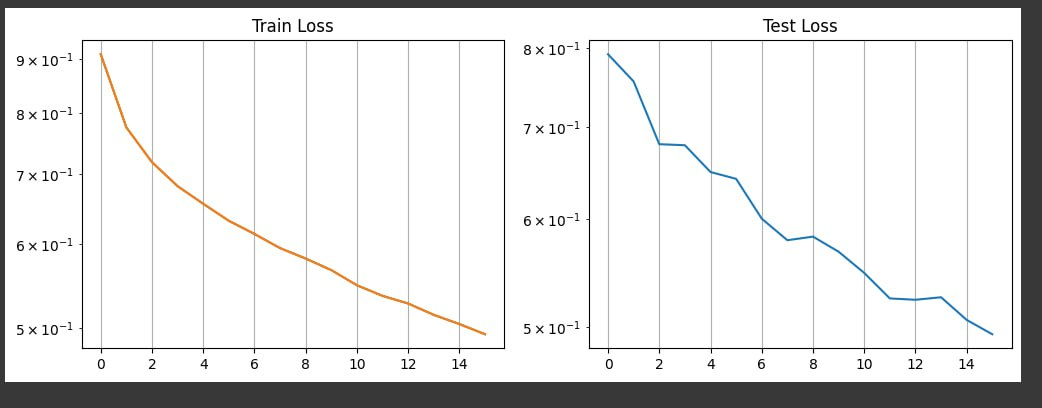
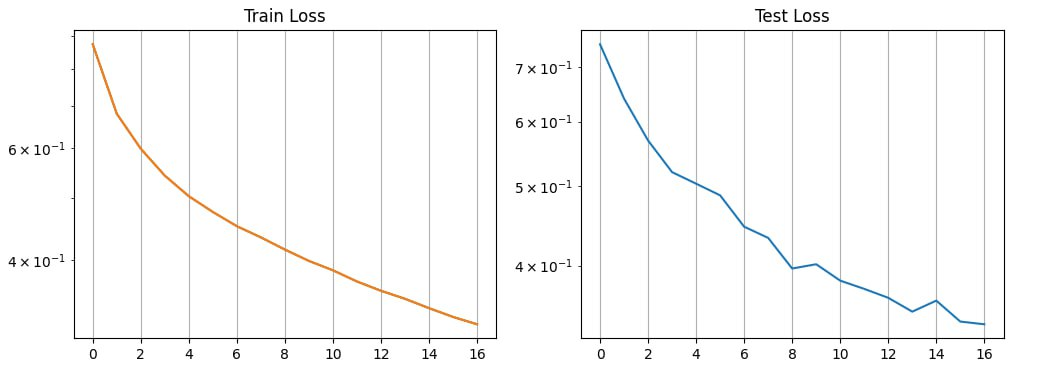

In [ ]:
# сохранение модели
path = './1maskmodeModel.pt'
torch.save(model.state_dict(), path)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# вывод метрик f1 и min_loss
y_true = []
pred = []
for X, y in test_loader:
    y_true.extend(np.array(y))
for i in range(len(predictions)):
    pred.extend(predictions[i].cpu().numpy())

print(f"f1_score = {f1_score(y_true, pred, average='weighted', zero_division=1)}")
print(f"min_loss = {min_loss}")

0.8799931061711159
0.2964483008846729


In [ ]:
# код для сабмита / выгрузка модели и применение модели на тестовый датасет
path = '/content/CNN.pt'
model = CNN()
model.load_state_dict(torch.load(path))
model.eval()
# создание тестового датасета
test_dataset = TestDataset()
test_dataloader = DataLoader(test_dataset, 32)
predictions = []

for images in test_dataloader:
  raw_predictions = model(images)
  # т.к. последний слой в архитектуре CNN модели линейный, нужно преобразовать его результат в вероятности
  updated_predictions = nn.Softmax(1)(raw_predictions)
  # с помощью argmax выбираем класс, вероятность которого больше
  predictions.extend(updated_predictions.argmax(1))
# преобразование предсказаний из тензоров в числа
for i in range(6920):
  predictions[i] = int(predictions[i])


In [ ]:
# мы обучили CNN на датасете с mask_mode = 0, получили предсказания, а после на mask_mode = 1 с инверсией цветов

# результаты на тестовом датасете первой обученной модели
p1 = np.array(predictions)
np.save('p1.npy', p1)
# результаты на тестовом датасете второй обученной модели
p = np.array(predictions)
np.save('p2.npy', p)

# берем среднее значение результатов 2 моделей
predictions = (p + p1) / 2
predictions = predictions.argmax(1)
for i in range(6920):
  predictions[i] = int(predictions[i])


In [ ]:
# создание датафрейма для сабмишенов
df = pd.DataFrame(predictions, columns=["target_feature"])
df.insert(loc=0, column='id', value=range(6920))
df.to_csv('Submission_2.csv', index=False)


# Вывод

В ходе работы над проектом были рассмотренны несколько архитектур сверточных моделей разной глубины. Разные методы предобработки данных: аугментированные данные, не аугментированные данные, инверсия цветов, сегментация тестовых данных, добавление аугментированных изображений в датасет. А также совмещали результаты моделей, обученных на разных данных, но это не дало лучший результат.

Лучший результат (f1 = 0.91157) мы получили на CNN модели с mask_mode = 0 на датасете, содержащем исходные и аугментированные картинки (54 эпохи, далее пошло переобучение). А второй лучший результат (f1 = 0.91055) мы получили на CNN модели с mask_mode = 0 на датасете с инверсией цветов.

В определенный момент наших эксперементов мы начали получать вот такие графики, представленные внизу. С чем это было связано мы не выяснили, само пофиксилось со временем, полагаем, что где-то было механическая ошибка в виде ошибки в коде/запуске ячеек в каком-то месте не в том порядке.

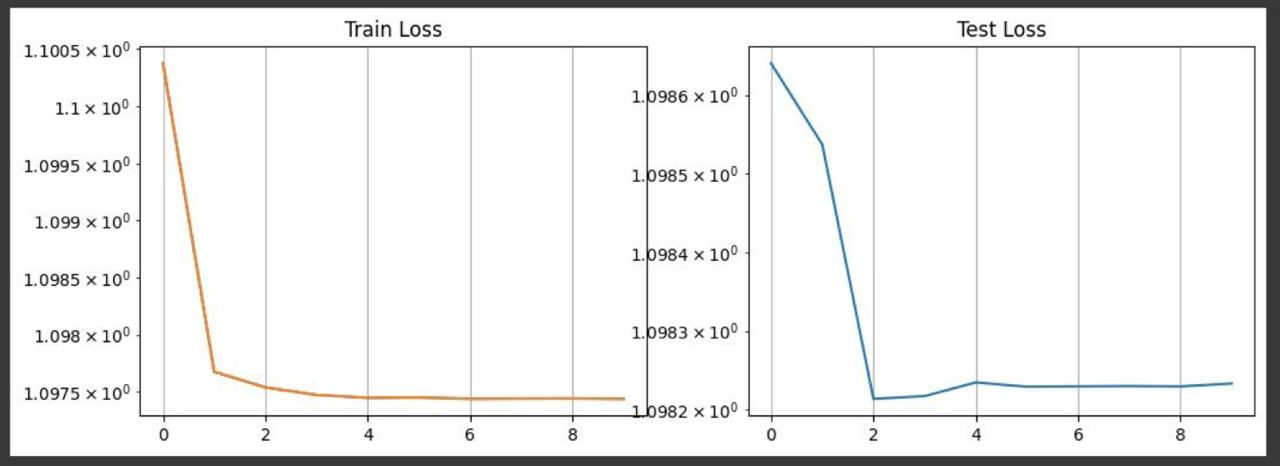
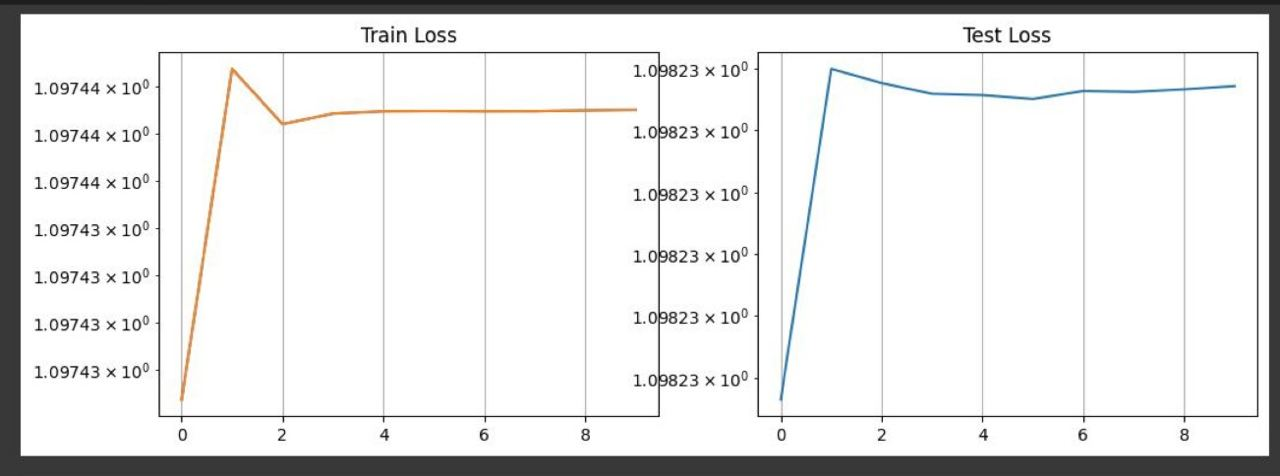
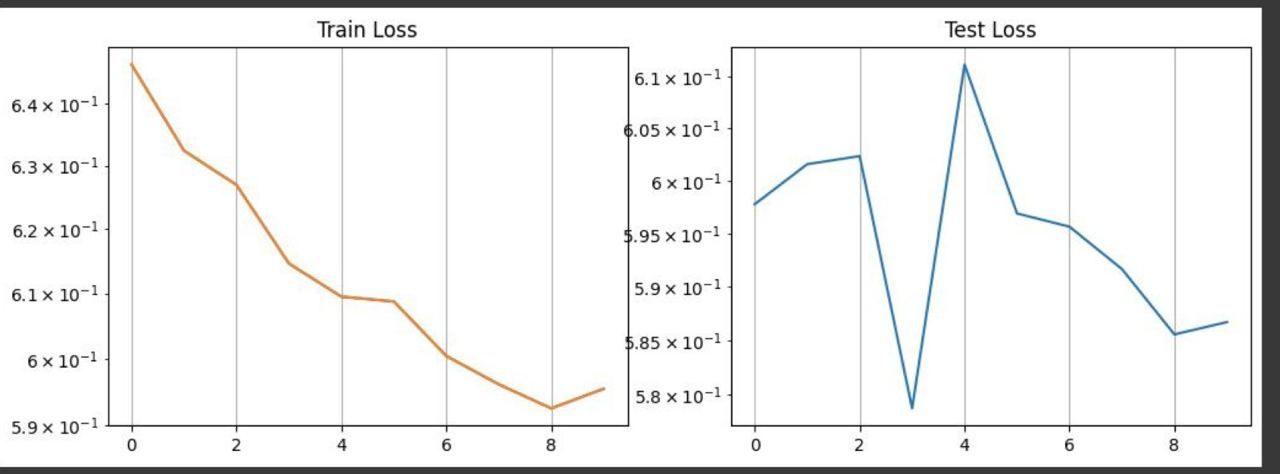